# Historical Stock Revenue Analysis

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D



In [2]:
def get_benchmark_index_per_country(country):
    country_index_df = pd.read_csv('country_index_mapping.csv')
    if country in country_index_df['Country'].values:
        index = country_index_df.loc[country_index_df['Country'] == country, 'Index'].values[0]
    else:
        index = None
    return index

In [3]:
def get_market_data(country,period='max'):
    benchmark_index_symbol = get_benchmark_index_per_country(country)
    if benchmark_index_symbol == None:
        return None,None
    else:
        market_df = pd.DataFrame(yf.Ticker(benchmark_index_symbol).history(period=period))
        market_df = market_df.rename(columns={'Close':'Adj_Close'})
        market_df['Daily_Returns'] = (market_df['Adj_Close'] + market_df['Dividends'] - market_df['Adj_Close'].shift(1))/market_df['Adj_Close'].shift(1)
        market_variance = market_df['Daily_Returns'].var()
        return market_df['Daily_Returns'],market_variance

In [4]:
def get_stock_data(symbol,period='max'):
    if symbol[-3:] == '.HK':
        country = 'Hong Kong'
    else:
        country = yf.Ticker(symbol).info['country']

    stock_df = pd.DataFrame(yf.Ticker(symbol).history(period=period))
    #yfinance returns adj close as close automatically
    stock_df = stock_df.rename(columns={'Close':'Adj_Close'})
    stock_df['Daily_Returns'] = (stock_df['Adj_Close'] + stock_df['Dividends'] - stock_df['Adj_Close'].shift(1))/stock_df['Adj_Close'].shift(1)
    expected_return = stock_df['Daily_Returns'].mean()
    stock_volatility = stock_df['Daily_Returns'].std()

    market_daily_returns,market_variance = get_market_data(country,period)
    if market_variance != None:
        beta = (market_daily_returns.cov(stock_df['Daily_Returns']))/market_variance
    else:
        beta = None
    return stock_df, expected_return, stock_volatility, beta, country

In [5]:
def display_stock_data(symbol,period='max'):
    print(f"{symbol}'s Data:")
    stock_df,expected_return,stock_volatility, beta, country = get_stock_data(symbol, period)
    print(f"Location: {country}")
    print(f"Stock Volatility: {stock_volatility*100:.2f}%")
    if beta != None:
        print(f"Stock Market Exposure: {beta:.4f}", end='')
        if beta > 1:
            print(" - High systematic risk.")
        elif beta <= 1 and beta > 0:
            print(" - Low systematic risk.")
        elif beta == 0:
            print(" - Uncorrelated.")
        elif beta < 0:
            print(" - Inverse systematic risk.")
        else:
            print(" - Error, most likely due to insufficient data or extreme stock volatility")
    else:
        print("Stock's country not available in database")

    colors = ['steelblue','orangered']
    
    stock_df['Adj_Close'].plot(figsize=(12,8), color = colors[0])
    plt.title('Adjusted Close Price')
    plt.grid()
    plt.show()

    ax = stock_df['Daily_Returns'].plot(figsize=(12,8), color = colors[0])
    plt.axhline(y=expected_return, color=colors[1], linestyle='--')
    custom_lines = [Line2D([0], [0], color=colors[0], lw=4), Line2D([0], [0], color=colors[1], lw=4)]
    ax.legend(custom_lines, ['Daily Returns','Expected Return'])
    plt.title('Daily Returns vs Expected Return')
    plt.grid()
    plt.show()

005930.KS's Data:
Location: South Korea
Stock Volatility: 1.54%
Stock Market Exposure: 0.9934 - Low systematic risk.


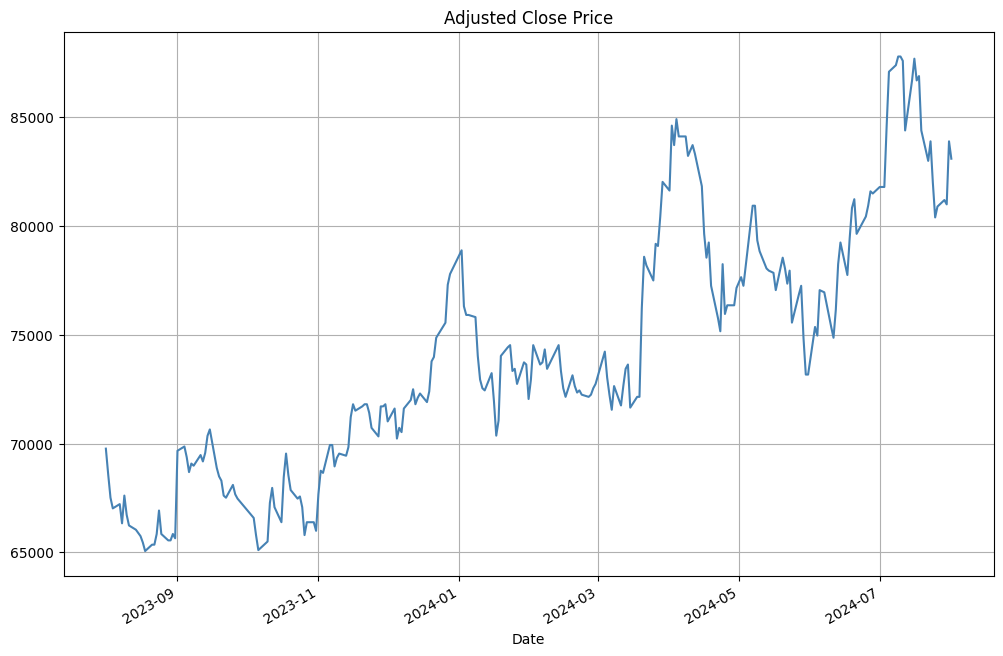

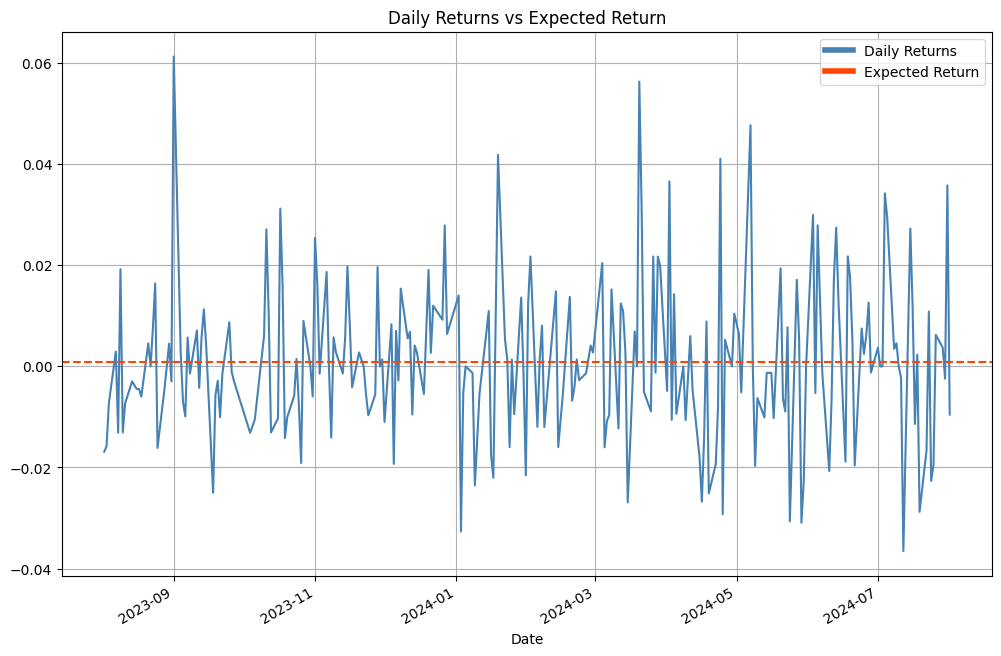

GOOGL's Data:
Location: United States
Stock Volatility: 1.73%
Stock Market Exposure: 1.3508 - High systematic risk.


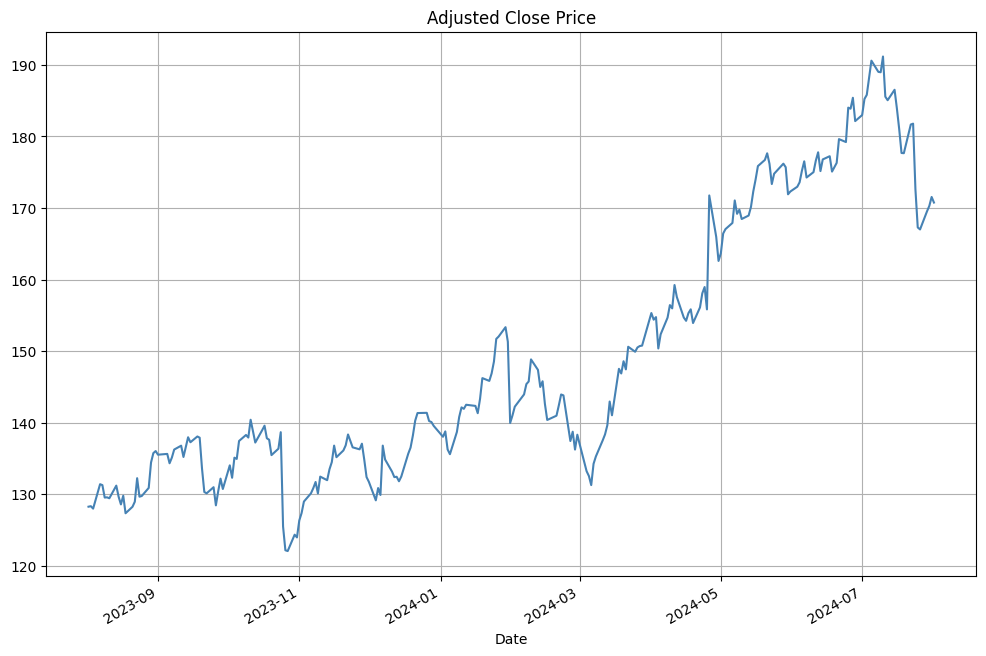

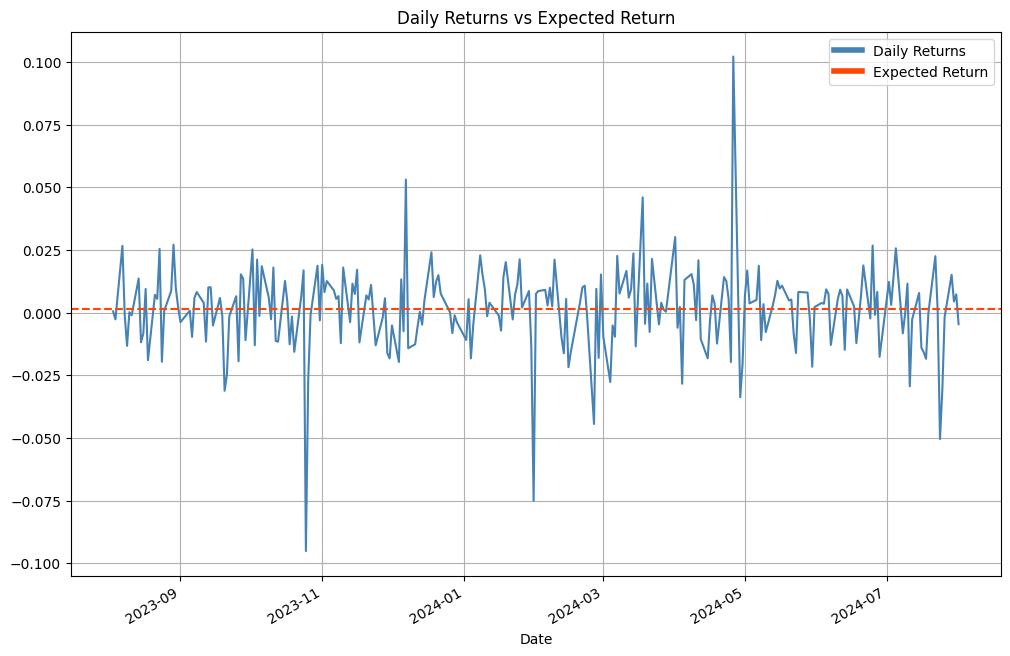

In [6]:
display_stock_data('005930.KS', '1y')
display_stock_data('GOOGL', '1y')